# Система классификации изображений драгоценных камней на основе сверточных нейронных сетей

## Теоретическая база

Сверточные нейронные сети являются основным инструментом для задач компьютерного зрения. В отличие от полносвязных сетей, CNN используют операцию свертки для эффективного извлечения пространственных признаков из изображений.

Основные компоненты:
* Сверточные слои - извлекают признаки и увеличивают количество измерений.
* Пулинговые слои - уменьшают пространственную размерность
* Функции активации (ReLU) - добавляют нелинейность
* Полносвязные слои - выполняют классификацию на основе извлеченных признаков

В работе используются предобученные на ImageNet модели.  

* ResNet50 - архитектура с остаточными связями
* ResNet18 - легковесная версия ResNet
* EfficientNet-B3 - современная архитектура, оптимизирующая глубину, ширину и разрешение

Для оценки моделей использовались следующие метрики:
* F1-score (weighted) - взвешенное по размеру классов среднее
* Confusion Matrix - матрица ошибок для анализа проблемных классов
Так же Accuracy и F1-score (macro) - но они не являлись основными метриками для оценки моделей.



## Описание разработанной системы

### Зависимости

In [ ]:
%pip install kagglehub
%pip install torch
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install seaborn
%pip install pandas
%pip install torchvision


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached scipy-1.17.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 9.6 MB/s  0:00:016m0:00:0100:01
Using cached scipy-1.17.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (35.0 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import shutil
from collections import defaultdict
import random
from tabulate import tabulate


### Датасет

Использован датасет "Gemstones Images" с Kaggle (lsind18/gemstones-images). Датасет содержит изображения 87 видов различных драгоценных камней. Всего в датасете около 3000. Для обучения датасет поделен на train, test, split (60/20/20).

#### Скачивание и распаковка датасета

In [2]:
path = kagglehub.dataset_download("lsind18/gemstones-images")

In [3]:
base_dir = 'data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [4]:
target_dir = base_dir

In [5]:
def collect_all_images(dataset_path):
    """
    Собирает все изображения из папок train и test оригинального датасета
    Возвращает словарь: {класс: [список путей к изображениям]}
    """
    all_images = defaultdict(list)
    
    # Проходим по папкам train и test
    for split in ['train', 'test']:
        split_path = os.path.join(dataset_path, split)
        if not os.path.exists(split_path):
            print(f"Папка {split_path} не найдена")
            continue
            
        # Проходим по классам в каждой папке
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if not os.path.isdir(class_path):
                continue
                
            # Собираем все изображения в этом классе
            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    img_path = os.path.join(class_path, img_file)
                    all_images[class_name].append(img_path)
    
    return all_images

# Собираем все изображения
all_images = collect_all_images(path)


In [6]:
def split_and_save_dataset(all_images, target_base_dir, train_ratio=0.6, val_ratio=0.2, seed=42):
    random.seed(seed)
    
    for class_name, image_paths in sorted(all_images.items()):
        # Перемешиваем изображения
        random.shuffle(image_paths)
        
        # Вычисляем размеры выборок
        total = len(image_paths)
        n_train = int(total * train_ratio)
        n_val = int(total * val_ratio)
        
        # Разделяем на три части
        train_paths = image_paths[:n_train]
        val_paths = image_paths[n_train:n_train + n_val]
        test_paths = image_paths[n_train + n_val:]
        
        # Создаем папки для класса
        for split in ['train', 'val', 'test']:
            class_dir = os.path.join(target_base_dir, split, class_name)
            os.makedirs(class_dir, exist_ok=True)
        
        # Копируем файлы
        # Train
        for src_path in train_paths:
            filename = os.path.basename(src_path)
            dst_path = os.path.join(target_base_dir, 'train', class_name, filename)
            shutil.copy2(src_path, dst_path)
        
        # Validation
        for src_path in val_paths:
            filename = os.path.basename(src_path)
            dst_path = os.path.join(target_base_dir, 'val', class_name, filename)
            shutil.copy2(src_path, dst_path)
        
        # Test
        for src_path in test_paths:
            filename = os.path.basename(src_path)
            dst_path = os.path.join(target_base_dir, 'test', class_name, filename)
            shutil.copy2(src_path, dst_path)
            
# Запускаем разделение
split_stats = split_and_save_dataset(all_images, target_dir, train_ratio=0.6, val_ratio=0.2)

Датасет скачан и перераспределен на 3 части вместо 2х как было изначально.

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")

Используется устройство: cpu


In [8]:
NUM_EPOCHS = 15
BATCH_SIZE = 32
LEARNING_RATE = 0.01

#### Загрузка датасета в код

В следующем отрезке кода, пытаемся сделать учебные фотографии максимально разными поворачивать их, зеркалить изменять яркость и контрастность, но это снизило эффективность обучения. И приводим все остальные фотографии к формату 224х224

In [9]:
data_dir = target_dir

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [11]:

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}

#### Размеры датасета 
В выводе следующей ячейки приведены размеры датасета

In [12]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print(f"Классы: {class_names}")
print(f"Размеры датасета: Train: {dataset_sizes['train']}, Val: {dataset_sizes['val']}, Test: {dataset_sizes['test']}")

Классы: ['Alexandrite', 'Almandine', 'Amazonite', 'Amber', 'Amethyst', 'Ametrine', 'Andalusite', 'Andradite', 'Aquamarine', 'Aventurine Green', 'Aventurine Yellow', 'Benitoite', 'Beryl Golden', 'Bixbite', 'Bloodstone', 'Blue Lace Agate', 'Carnelian', 'Cats Eye', 'Chalcedony', 'Chalcedony Blue', 'Chrome Diopside', 'Chrysoberyl', 'Chrysocolla', 'Chrysoprase', 'Citrine', 'Coral', 'Danburite', 'Diamond', 'Diaspore', 'Dumortierite', 'Emerald', 'Fluorite', 'Garnet Red', 'Goshenite', 'Grossular', 'Hessonite', 'Hiddenite', 'Iolite', 'Jade', 'Jasper', 'Kunzite', 'Kyanite', 'Labradorite', 'Lapis Lazuli', 'Larimar', 'Malachite', 'Moonstone', 'Morganite', 'Onyx Black', 'Onyx Green', 'Onyx Red', 'Opal', 'Pearl', 'Peridot', 'Prehnite', 'Pyrite', 'Pyrope', 'Quartz Beer', 'Quartz Lemon', 'Quartz Rose', 'Quartz Rutilated', 'Quartz Smoky', 'Rhodochrosite', 'Rhodolite', 'Rhodonite', 'Ruby', 'Sapphire Blue', 'Sapphire Pink', 'Sapphire Purple', 'Sapphire Yellow', 'Scapolite', 'Serpentine', 'Sodalite', 'Spe

### Модель

#### Скачиваем и изменяем модель
Заменяем последний слой на 87 классов

In [37]:
model_ft = models.resnet50(weights='IMAGENET1K_V1')
model_ft.fc = nn.Linear(model_ft.fc.in_features, len(class_names))
#model_ft = models.efficientnet_b3(weights='IMAGENET1K_V1')
#model_ft.classifier[1] = nn.Linear(model_ft.classifier[1].in_features, len(class_names))

Название изменяемых слове зависит от модели, поэтому менял в ручную, хотя можно было бы наверное просто объединить.

In [38]:
for name, param in model_ft.named_parameters():
    if "fc.weight" not in name and "fc.bias" not in name:#if "classifier.1.weight" not in name and "classifier.1.bias" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

In [39]:
model_ft = model_ft.to(device)
total_params = sum(p.numel() for p in model_ft.parameters())
trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)

In [40]:
print(f"\nВсего параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")


Всего параметров: 23,686,295
Обучаемых параметров: 178,263 (0.8%)


Наша задача обучить в первую очередь классификатор, потому что модель и так определяет все особенности картинки так как она обучена под ImageNet. Максимальная доля обучаемых параметров была 4%.

#### Обучение классификатора

##### Функция потерь
В качестве функции потерь была использована CrossEntropyLoss. Это стандартная функция потерь для задач многоклассовой классификации.

##### Оптимизатор
SGD vs AdamW - по идее оптимизатор AdamW должен давать более быструю сходимость и в целом лучше работать. Единственная его проблема в том, что он может вызывать переоучение. Как можно будет заметить дальше, к переобучению модель была и не близка. Но по какой-то причине при прочих вводных оптимизатор SGD справился лучше.

##### Планировщик обучаемости
StepLR vs CosineAnnealingLR - 1 сбрасывает lr на каждом step_size шаге в gamma раз, а второй постепенно каждый раз. Опять е чисто практически StepLR показал себя лучше.

In [41]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=LEARNING_RATE, momentum=0.9)
#optimizer_ft = optim.AdamW(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=LEARNING_RATE, weight_decay=0.01 )

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
#exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=NUM_EPOCHS)

##### Обучаем
Если после валидации получается лучший результат мы его сохраняем.

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    epoch_pbar = tqdm(range(num_epochs), desc='Epochs', position=0)
    
    for epoch in epoch_pbar:
        epoch_pbar.set_description(f'Epoch {epoch}/{num_epochs-1}')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                pbar = tqdm(dataloaders[phase], desc=f'Training', 
                           leave=False, position=1)
            else:
                model.eval()
                pbar = tqdm(dataloaders[phase], desc=f'Validation', 
                           leave=False, position=1)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'train':
                    pbar.set_postfix({
                        'loss': f'{loss.item():.4f}',
                        'acc': f'{torch.sum(preds == labels.data).item()/len(labels):.4f}'
                    })
                else:
                    pbar.set_postfix({
                        'val_acc': f'{torch.sum(preds == labels.data).item()/len(labels):.4f}'
                    })

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                epoch_pbar.set_postfix({
                    'train_loss': f'{epoch_loss:.4f}',
                    'train_acc': f'{epoch_acc:.4f}'
                })
            else:
                epoch_pbar.set_postfix({
                    'val_loss': f'{epoch_loss:.4f}',
                    'val_acc': f'{epoch_acc:.4f}'
                })

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
    time_elapsed = time.time() - since
    print(f'\n Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f' Best val Acc: {best_acc:.4f}')

    # Загружаем лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                num_epochs=NUM_EPOCHS)

Epoch 14/14: 100%|██████████| 15/15 [42:49<00:00, 171.31s/it, train_loss=0.6231, train_acc=0.8648, val_loss=1.0255, val_acc=0.7010]


 Training complete in 42m 50s
 Best val Acc: 0.7059


##### Сохранение натренированной модели

In [20]:
model_path = 'best_model_resNet50_NotShifted.pth'
torch.save(model_ft.state_dict(), model_path)

## Метрики и результаты

### Загрузка модели
Открываем обученые модели и создаем словарь из них по названию, переводим их в режим оценки.

In [13]:
models_dict = {}
folder_path='models'
if not os.path.exists(folder_path):
    print(f"❌ Папка '{folder_path}' не найдена!")
else:     
    for filename in os.listdir(folder_path):
        if filename.endswith(".pth"):
            filename=folder_path+"/"+filename
            if "18" in filename:
                model = models.resnet18(weights=None) 
            elif "efficientnet_b3" in filename:
                model=models.efficientnet_b3(weights=None)
            else:
                model=models.resnet50(weights=None)
            if "efficientnet_b3" in filename:
                model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
            else:
                model.fc = nn.Linear(model.fc.in_features, len(class_names))
            checkpoint = torch.load(filename, map_location=device)
            if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
                    model.load_state_dict(checkpoint['model_state_dict'])
            else:
                    model.load_state_dict(checkpoint)
            
            model = model.to(device)
            model.eval() 
            
            models_dict[filename] = model
            
print(f"\nЗагружено моделей: {len(models_dict)}")


Загружено моделей: 5


## Снимаем метрики

#### Описание снятие метрик

##### evaluate_model_with_f1
Функция считает метрики для модели на тестовой выборке и сохраняет прогнозы модели для дальнейших манипуляций

In [14]:
def evaluate_model_with_f1(model, dataloader, class_names, dataset_size):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    print("-" * 50)
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Преобразуем в numpy массивы
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # 1. Считаем accuracy (для сравнения)
    accuracy = np.mean(all_preds == all_labels)
    
    # 2. Считаем macro F1-score (среднее по классам)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    
    # 3. Считаем weighted F1-score (взвешенное по поддержке классов)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    
    # 4. Считаем per-class F1-score
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score (macro): {f1_macro:.4f}")
    print(f"F1-score (weighted): {f1_weighted:.4f}")
    print()
    
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

    print(f"{'Среднее (macro)':<25} {report['macro avg']['precision']:<10.4f} {report['macro avg']['recall']:<10.4f} {report['macro avg']['f1-score']:<10.4f} {dataset_size:<10.0f}")
    
    return all_preds, all_labels, all_probs, {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'f1_per_class': f1_per_class,
        'report': report
    }

##### plot_confusion_matrix

Рисует матрицу оршибок, а так же считает наиболее частые ошибки при классификации для каждой модели. ПО сути хватило бы сделать это 1 раз, так как там действительно есть классы, которые очень похожи между собой.

In [ ]:
def plot_confusion_matrix(all_labels, all_preds, class_names):
    # Вычисляем матрицу ошибок
    cm = confusion_matrix(all_labels, all_preds)
    
    # Создаем фигуру
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # 1. Абсолютные значения (тепловая карта без подписей)
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=False, yticklabels=False,  # Убираем подписи
                ax=axes[0], cbar_kws={'label': 'Количество изображений'})
    axes[0].set_title('Матрица ошибок (абсолютные значения)\n87 классов', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Истинный класс', fontsize=12)
    axes[0].set_xlabel('Предсказанный класс', fontsize=12)
    
    # 2. Нормализованные значения (тепловая карта без подписей)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='YlOrRd', 
                xticklabels=False, yticklabels=False,  # Убираем подписи
                ax=axes[1], cbar_kws={'label': 'Доля от класса'}, 
                vmin=0, vmax=1)
    axes[1].set_title('Матрица ошибок (нормализованная по строкам)\n87 классов', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Истинный класс', fontsize=12)
    axes[1].set_xlabel('Предсказанный класс', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    print("\n Анализ самых частых ошибок:")
    print("=" * 60)
    
    # Общая статистика
    total_samples = len(all_labels)
    correct = np.trace(cm)
    accuracy = correct / total_samples
    
    print(f" Всего изображений: {total_samples}")
    print(f" Правильно: {correct} ({accuracy:.2%})")
    print(f" Ошибок: {total_samples - correct} ({1-accuracy:.2%})")
    print("-" * 60)
    
    cm_errors = cm.copy()
    np.fill_diagonal(cm_errors, 0)
    
    errors = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if cm_errors[i, j] > 0:
                errors.append((cm_errors[i, j], i, j))
    
    errors.sort(reverse=True)
    
    print("\n Топ-10 самых частых ошибок:")
    for idx, (count, true_idx, pred_idx) in enumerate(errors[:10], 1):
        error_percent = count / cm[true_idx].sum() * 100
        print(f"{idx:2d}. {class_names[true_idx]:35} → {class_names[pred_idx]:35} : {count:4d} ({error_percent:.1f}%)")
    
    return cm, cm_normalized

##### evaluate_all_models

Оценивает все загруженные модели и возвращает сводную таблицу. Вызывает предыдущие функции.

In [ ]:
def evaluate_all_models(models_dict, dataloaders, class_names, device):
    results_summary = []
    
    for model_name, model in models_dict.items():
        print(f"\n{'='*60}")
        print(f"📊 Оценка модели: {model_name}")
        print(f"{'='*60}")
        
        # Получаем предсказания
        preds, labels, probs, metrics = evaluate_model_with_f1(
            model, dataloaders['test'], class_names, dataloaders['test'].dataset.__len__()
        )
        
        # Собираем основные метрики
        summary = {
            'Модель': model_name,
            'Accuracy': metrics['accuracy'],
            'F1 (macro)': metrics['f1_macro'],
            'F1 (weighted)': metrics['f1_weighted'],
            'Точность (macro)': metrics['report']['macro avg']['precision'],
            'Полнота (macro)': metrics['report']['macro avg']['recall'],
            'Размер теста': len(labels)
        }
        
        report_df = pd.DataFrame(metrics['report']).T
        classes_df = report_df[report_df.index.isin(class_names)]
        
        best_classes = classes_df.nlargest(3, 'f1-score')[['f1-score']]
        best_classes_list = []
        for idx, row in best_classes.iterrows():
            best_classes_list.append(f"{idx} ({row['f1-score']:.2f})")
        summary['Лучшие классы (F1)'] = ', '.join(best_classes_list)
        
        worst_classes = classes_df.nsmallest(3, 'f1-score')[['f1-score']]
        worst_classes_list = []
        for idx, row in worst_classes.iterrows():
            worst_classes_list.append(f"{idx} ({row['f1-score']:.2f})")
        summary['Худшие классы (F1)'] = ', '.join(worst_classes_list)
        
        low_f1_classes = sum(1 for f1 in metrics['f1_per_class'] if f1 < 0.5)
        summary['Классов с F1<0.5'] = f"{low_f1_classes}/{len(class_names)} ({low_f1_classes/len(class_names)*100:.1f}%)"
        
        results_summary.append(summary)
        
        plot_confusion_matrix(labels, preds, class_names)
    
    results_df = pd.DataFrame(results_summary)
    
    results_df = results_df.sort_values('F1 (macro)', ascending=False).reset_index(drop=True)
    
    return results_df

##### plot_models_comparison

Строит графики для сравнения моделей

In [ ]:
def plot_models_comparison(results_df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Сравнение Accuracy и F1-macro
    ax = axes[0, 0]
    x = range(len(results_df))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], results_df['Accuracy'], width, label='Accuracy', color='skyblue')
    ax.bar([i + width/2 for i in x], results_df['F1 (macro)'], width, label='F1-macro', color='lightcoral')
    
    ax.set_xlabel('Модели')
    ax.set_ylabel('Score')
    ax.set_title('Сравнение Accuracy и F1-macro')
    ax.set_xticks(x)
    ax.set_xticklabels([f"M{i+1}" for i in x], rotation=0)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Добавляем легенду с названиями моделей
    legend_text = "\n".join([f"M{i+1}: {name[:30]}..." for i, name in enumerate(results_df['Модель'])])
    ax.text(1.02, 0.5, legend_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 2. Сравнение Precision и Recall
    ax = axes[0, 1]
    ax.bar([i - width/2 for i in x], results_df['Точность (macro)'], width, label='Precision', color='lightgreen')
    ax.bar([i + width/2 for i in x], results_df['Полнота (macro)'], width, label='Recall', color='lightsalmon')
    
    ax.set_xlabel('Модели')
    ax.set_ylabel('Score')
    ax.set_title('Сравнение Precision и Recall')
    ax.set_xticks(x)
    ax.set_xticklabels([f"M{i+1}" for i in x], rotation=0)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Топ-3 модели по F1
    ax = axes[1, 0]
    top3 = results_df.head(3)
    colors = ['gold', 'silver', '#cd7f32']  # золото, серебро, бронза
    
    bars = ax.bar(range(len(top3)), top3['F1 (macro)'], color=colors)
    ax.set_xlabel('Модели')
    ax.set_ylabel('F1-macro')
    ax.set_title('Топ-3 модели по F1-macro')
    ax.set_xticks(range(len(top3)))
    ax.set_xticklabels([f"M{results_df.index.get_loc(i)+1}" for i in top3.index], rotation=0)
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3)
    
    for bar, val in zip(bars, top3['F1 (macro)']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Количество классов с низким F1
    ax = axes[1, 1]
    low_f1_counts = [int(row['Классов с F1<0.5'].split('/')[0]) for _, row in results_df.iterrows()]
    total_classes = len(class_names)
    
    bars = ax.bar(x, low_f1_counts, color='tomato', alpha=0.7)
    ax.axhline(y=total_classes/2, color='red', linestyle='--', alpha=0.5, label='50% классов')
    ax.set_xlabel('Модели')
    ax.set_ylabel('Количество классов с F1 < 0.5')
    ax.set_title(f'Проблемные классы (F1 < 0.5) из {total_classes}')
    ax.set_xticks(x)
    ax.set_xticklabels([f"M{i+1}" for i in x], rotation=0)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Печатаем соответствие номеров моделей
    print("\n🔍 Соответствие номеров моделей:")
    for i, name in enumerate(results_df['Модель']):
        print(f"   M{i+1}: {name}")


#### Результаты моделей

##### Результат каждой модели


📊 Оценка модели: models/best_model_efficientnet_b3.pth
--------------------------------------------------
Accuracy: 0.7450
F1-score (macro): 0.7381
F1-score (weighted): 0.7412

Среднее (macro)           0.7653     0.7425     0.7381     706       


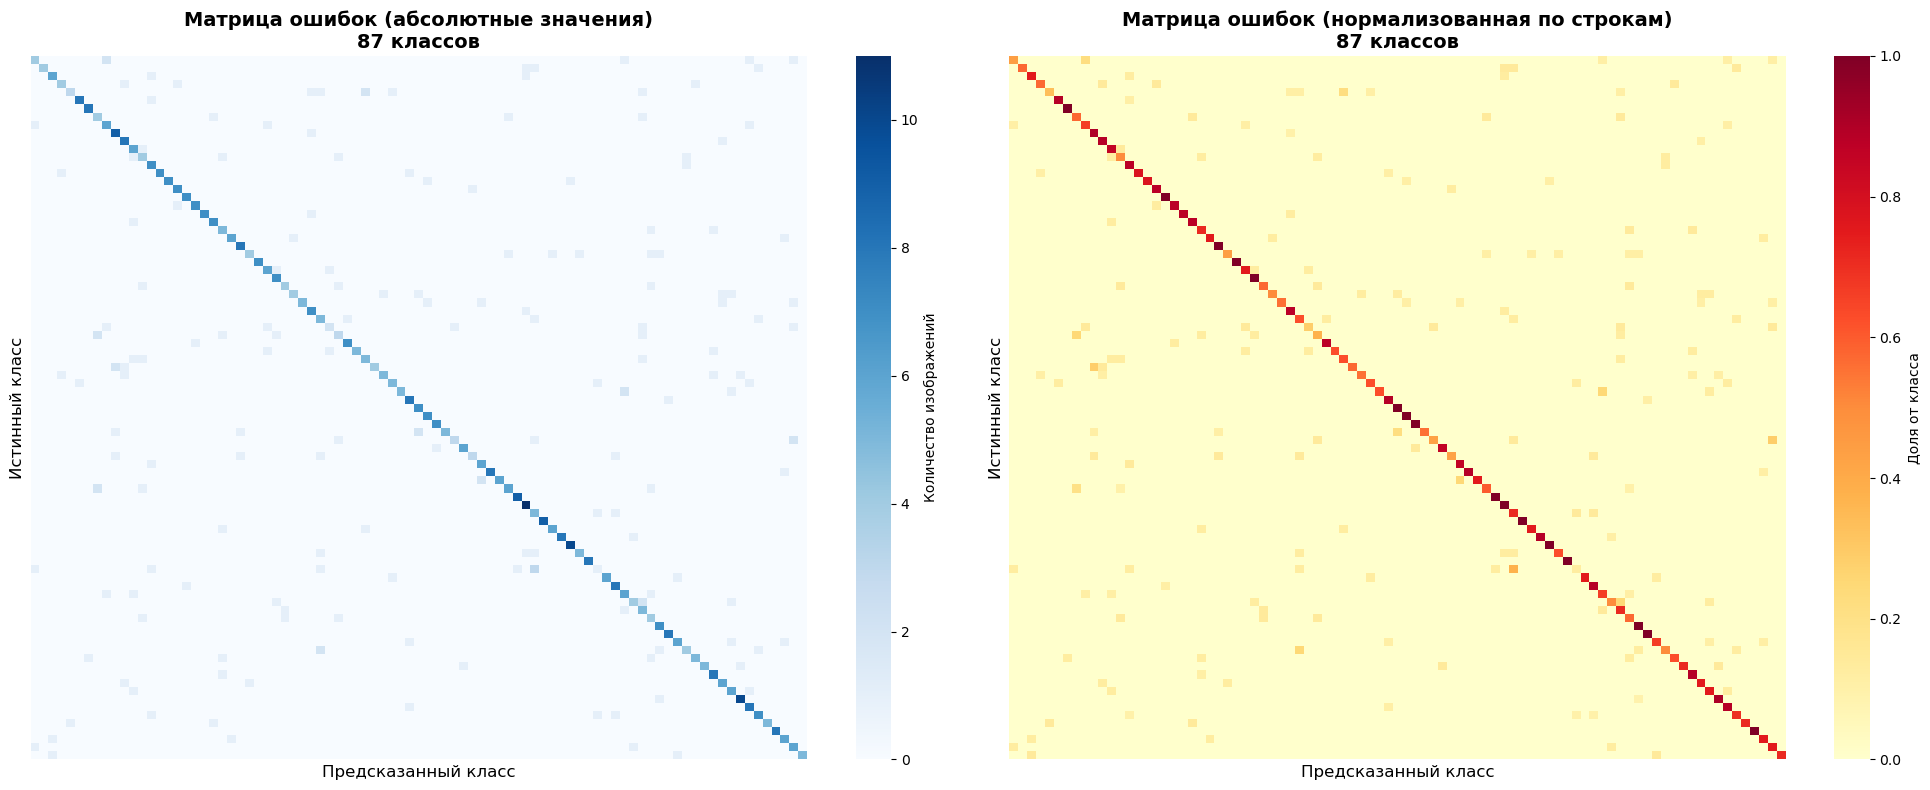


 Анализ самых частых ошибок:
 Всего изображений: 706
 Правильно: 526 (74.50%)
 Ошибок: 180 (25.50%)
------------------------------------------------------------

 Топ-10 самых частых ошибок:
 1. Rhodolite                           → Pyrope                              :    3 (37.5%)
 2. Spessartite                         → Garnet Red                          :    2 (25.0%)
 3. Sapphire Pink                       → Sapphire Purple                     :    2 (25.0%)
 4. Peridot                             → Andradite                           :    2 (20.0%)
 5. Pearl                               → Onyx Red                            :    2 (25.0%)
 6. Morganite                           → Zircon                              :    2 (28.6%)
 7. Moonstone                           → Lapis Lazuli                        :    2 (22.2%)
 8. Kyanite                             → Sapphire Blue                       :    2 (25.0%)
 9. Jade                                → Aventurine Green      

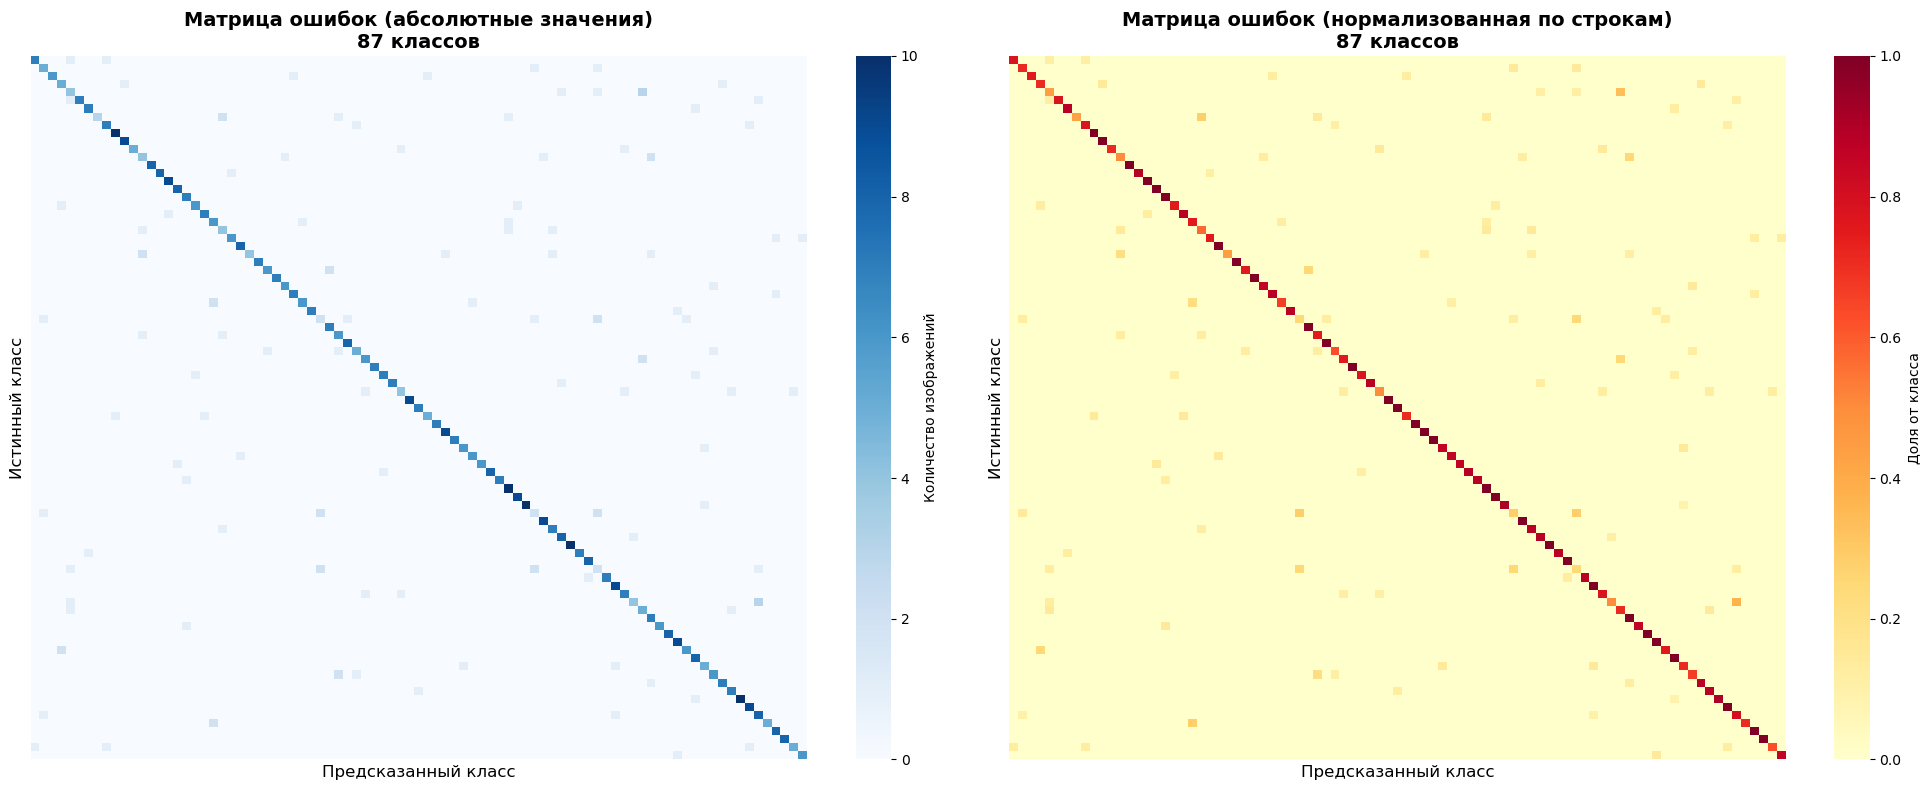


 Анализ самых частых ошибок:
 Всего изображений: 706
 Правильно: 584 (82.72%)
 Ошибок: 122 (17.28%)
------------------------------------------------------------

 Топ-10 самых частых ошибок:
 1. Sapphire Pink                       → Tourmaline                          :    3 (37.5%)
 2. Amethyst                            → Sapphire Purple                     :    3 (33.3%)
 3. Tsavorite                           → Chrome Diopside                     :    2 (28.6%)
 4. Spodumene                           → Grossular                           :    2 (22.2%)
 5. Spessartite                         → Amber                               :    2 (25.0%)
 6. Rhodolite                           → Pyrope                              :    2 (25.0%)
 7. Rhodolite                           → Garnet Red                          :    2 (25.0%)
 8. Pyrope                              → Rhodolite                           :    2 (28.6%)
 9. Pyrope                              → Garnet Red            

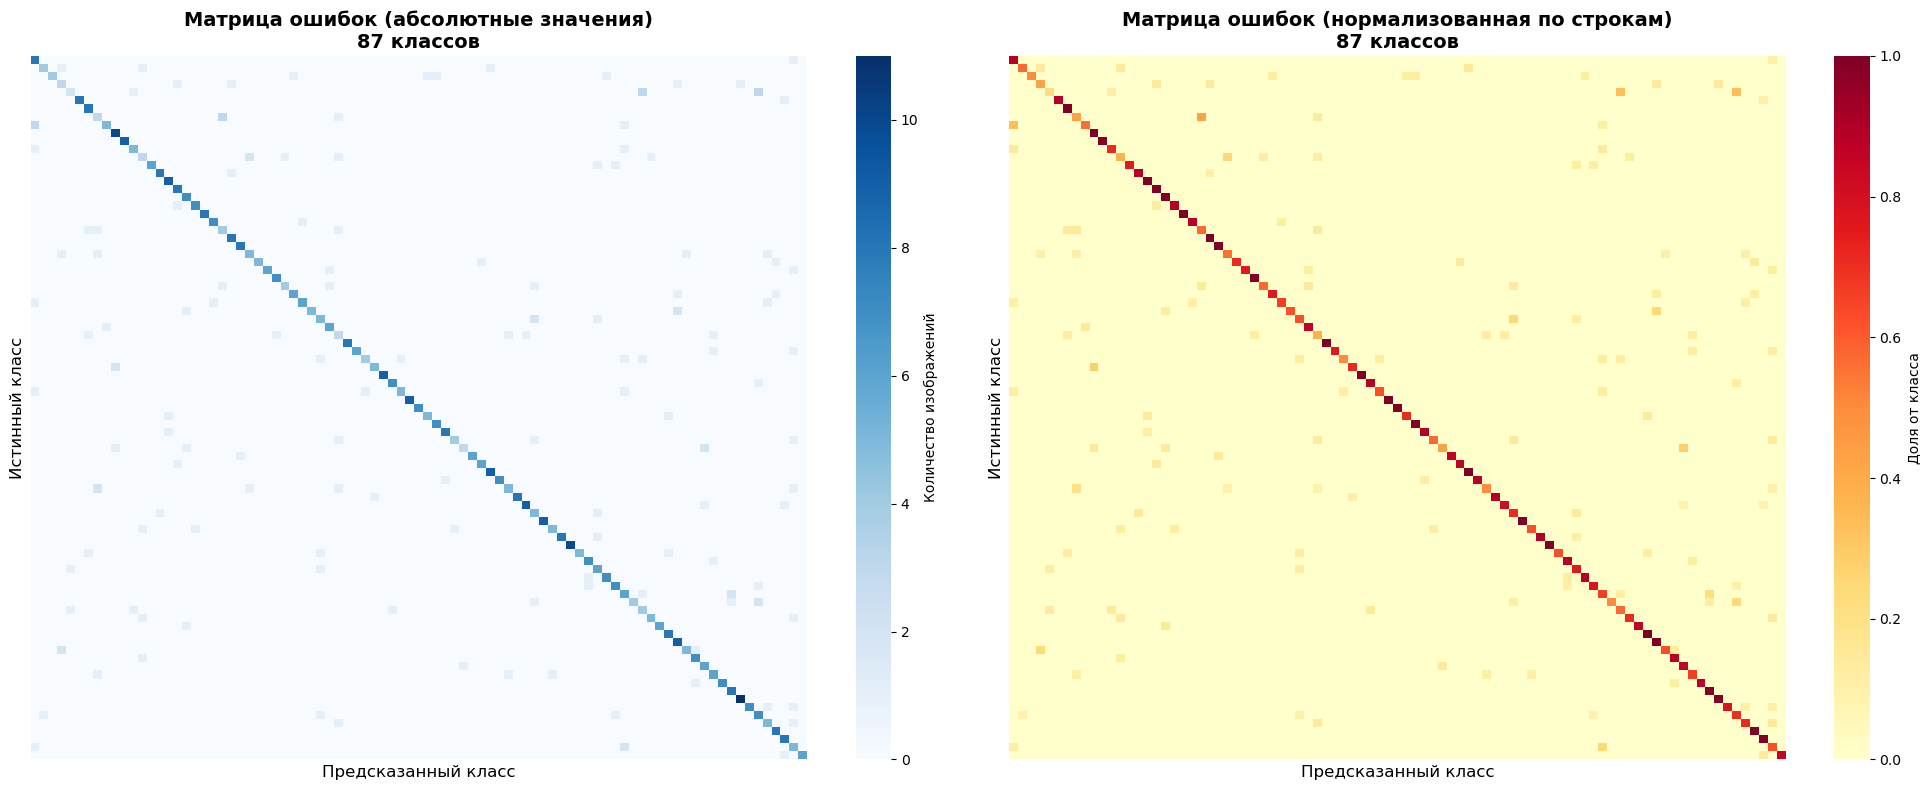


 Анализ самых частых ошибок:
 Всего изображений: 706
 Правильно: 554 (78.47%)
 Ошибок: 152 (21.53%)
------------------------------------------------------------

 Топ-10 самых частых ошибок:
 1. Aquamarine                          → Alexandrite                         :    3 (33.3%)
 2. Andradite                           → Chrysoberyl                         :    3 (42.9%)
 3. Amethyst                            → Tourmaline                          :    3 (33.3%)
 4. Amethyst                            → Sapphire Purple                     :    3 (33.3%)
 5. Zircon                              → Sapphire Blue                       :    2 (25.0%)
 6. Spessartite                         → Amber                               :    2 (25.0%)
 7. Sapphire Pink                       → Tourmaline                          :    2 (25.0%)
 8. Sapphire Blue                       → Tanzanite                           :    2 (22.2%)
 9. Peridot                             → Andradite             

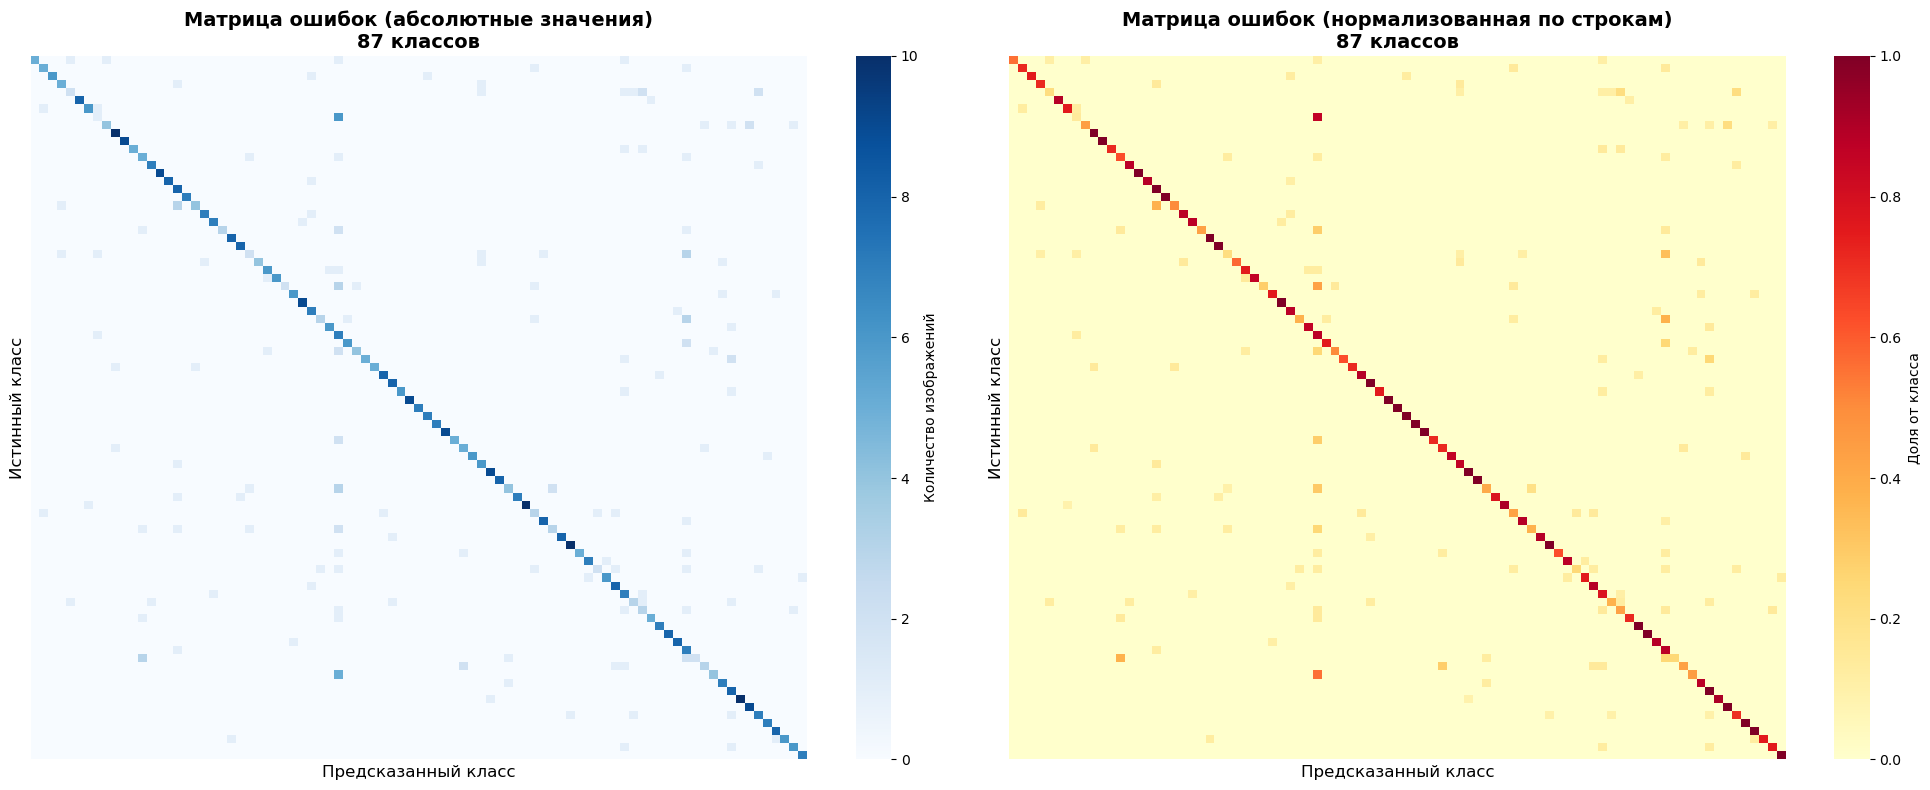


 Анализ самых частых ошибок:
 Всего изображений: 706
 Правильно: 538 (76.20%)
 Ошибок: 168 (23.80%)
------------------------------------------------------------

 Топ-10 самых частых ошибок:
 1. Andradite                           → Grossular                           :    6 (85.7%)
 2. Spodumene                           → Grossular                           :    5 (55.6%)
 3. Sphene                              → Beryl Golden                        :    3 (37.5%)
 4. Peridot                             → Grossular                           :    3 (30.0%)
 5. Garnet Red                          → Spessartite                         :    3 (37.5%)
 6. Diaspore                            → Grossular                           :    3 (42.9%)
 7. Citrine                             → Spessartite                         :    3 (33.3%)
 8. Chalcedony                          → Carnelian                           :    3 (37.5%)
 9. Spinel                              → Onyx Black            

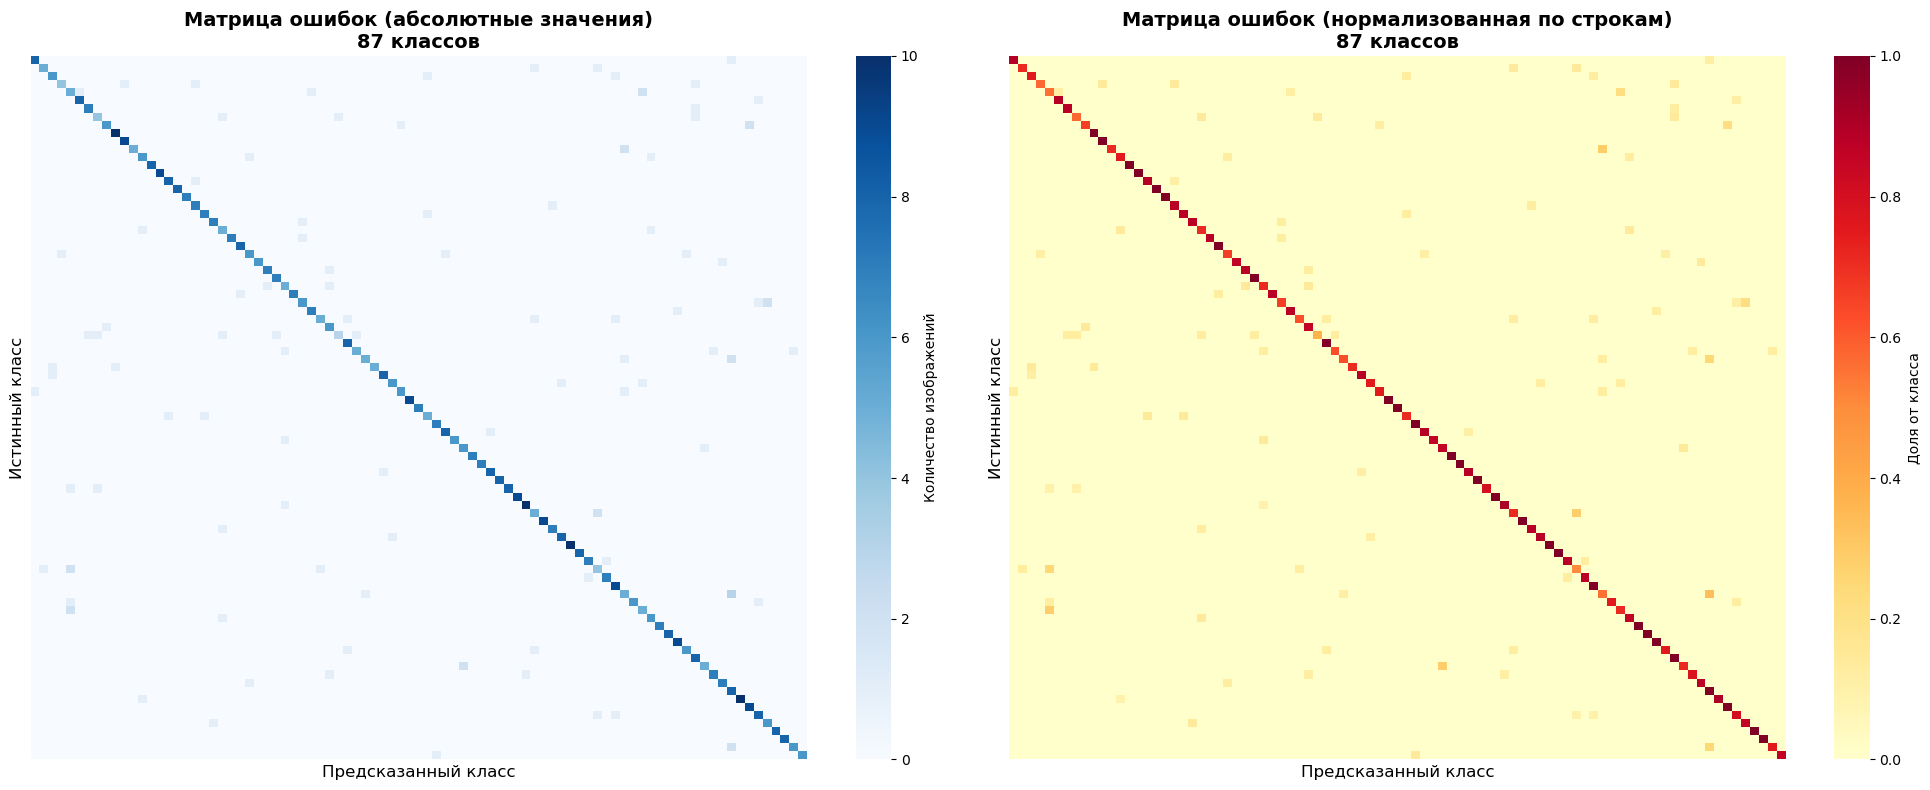


 Анализ самых частых ошибок:
 Всего изображений: 706
 Правильно: 599 (84.84%)
 Ошибок: 107 (15.16%)
------------------------------------------------------------

 Топ-10 самых частых ошибок:
 1. Sapphire Blue                       → Tanzanite                           :    3 (33.3%)
 2. Zircon                              → Tanzanite                           :    2 (25.0%)
 3. Spinel                              → Onyx Black                          :    2 (28.6%)
 4. Sapphire Purple                     → Amethyst                            :    2 (28.6%)
 5. Rhodolite                           → Amethyst                            :    2 (25.0%)
 6. Pyrope                              → Rhodolite                           :    2 (28.6%)
 7. Iolite                              → Tanzanite                           :    2 (25.0%)
 8. Emerald                             → Tsavorite                           :    2 (22.2%)
 9. Benitoite                           → Sapphire Blue         

In [ ]:
results_df = evaluate_all_models(models_dict, dataloaders, class_names, device)

##### Графики сравнивнения моделей

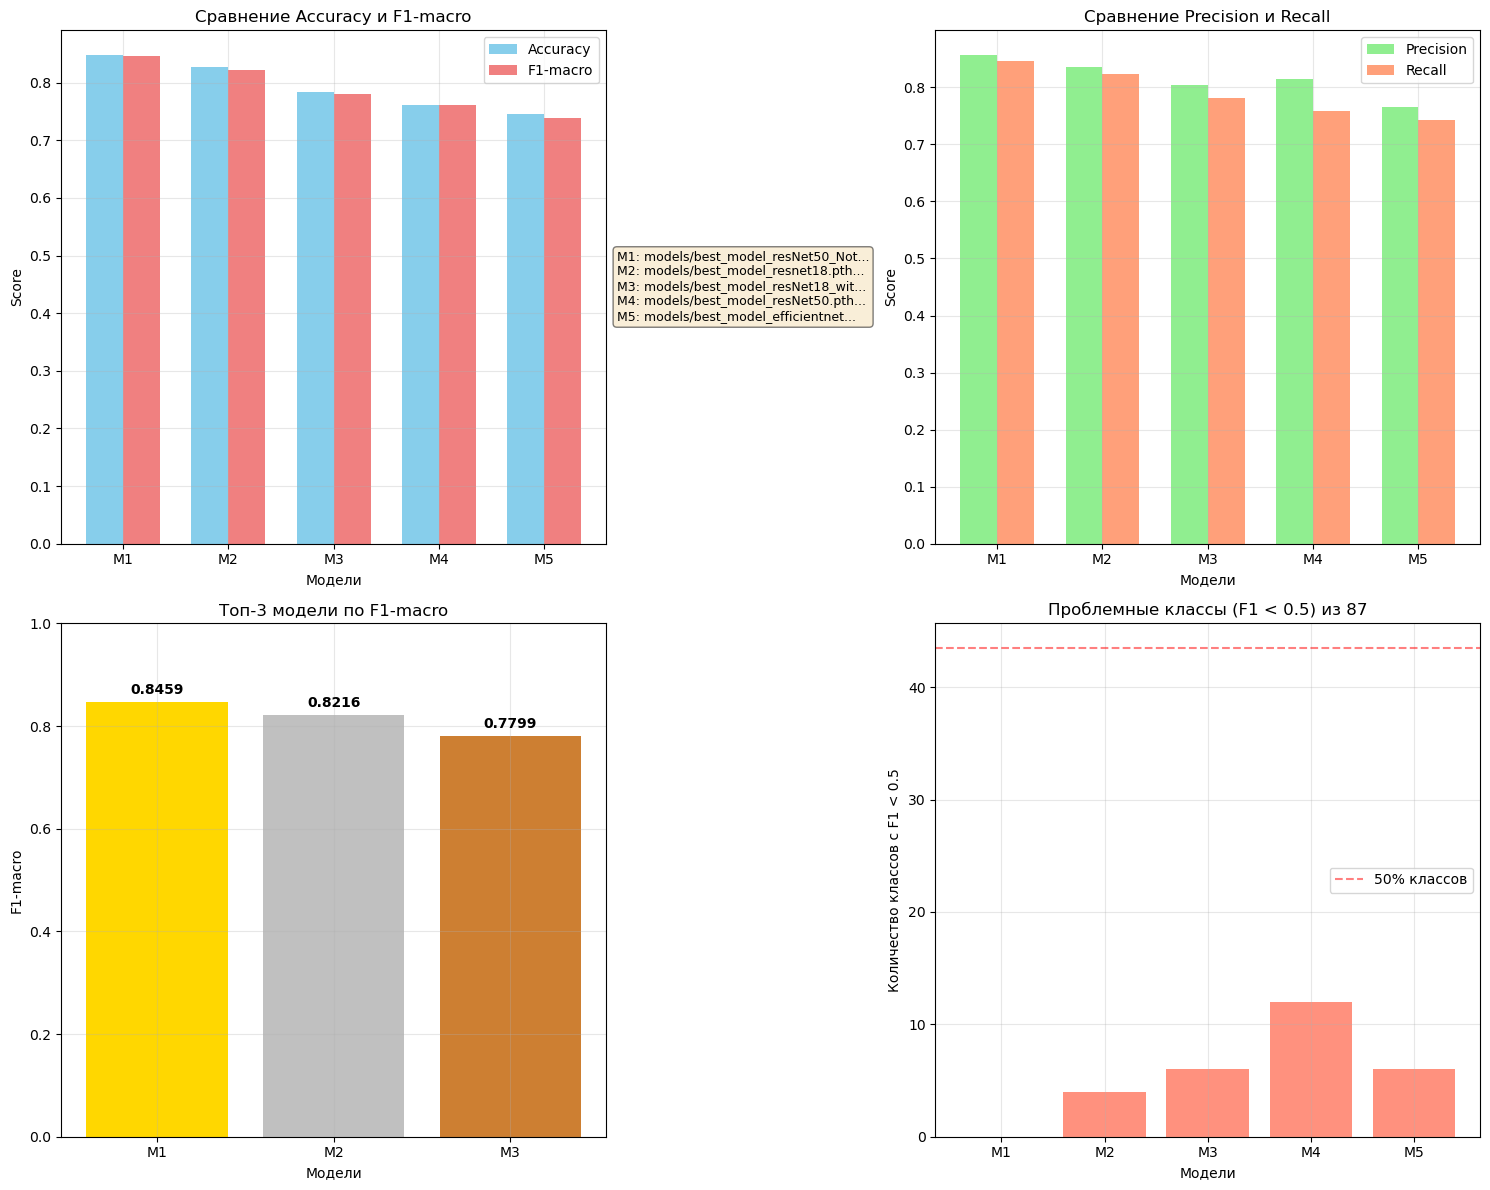


🔍 Соответствие номеров моделей:
   M1: models/best_model_resNet50_NotShifted.pth
   M2: models/best_model_resnet18.pth
   M3: models/best_model_resNet18_withShift.pth
   M4: models/best_model_resNet50.pth
   M5: models/best_model_efficientnet_b3.pth


In [19]:
plot_models_comparison(results_df)

##### Рисуем красивую сводную таблицу

In [ ]:
from IPython.display import display, HTML
    
def display_pretty_table(df):
        """
        Отображает красивую таблицу в Jupyter
        """
        styled_df = df.style.background_gradient(subset=['Accuracy', 'F1 (macro)', 'F1 (weighted)'], cmap='YlOrRd')
        styled_df = styled_df.format({
            'Accuracy': '{:.4f}',
            'F1 (macro)': '{:.4f}',
            'F1 (weighted)': '{:.4f}',
            'Точность (macro)': '{:.4f}',
            'Полнота (macro)': '{:.4f}'
        })
        
        styled_df = styled_df.highlight_max(subset=['Accuracy', 'F1 (macro)', 'F1 (weighted)'], color='lightgreen')
        
        display(styled_df)
    
display_pretty_table(results_df)

,Модель,Accuracy,F1 (macro),F1 (weighted),Точность (macro),Полнота (macro),Размер теста,Лучшие классы (F1),Худшие классы (F1),Классов с F1<0.5
0,models/best_model_resNet50_NotShifted.pth,0.8484,0.8459,0.8482,0.8571,0.8460,706,"Bixbite (1.00), Bloodstone (1.00), Carnelian (1.00)","Amethyst (0.50), Grossular (0.50), Rhodolite (0.50)",0/87 (0.0%)
1,models/best_model_resnet18.pth,0.8272,0.8216,0.8245,0.8350,0.8241,706,"Bixbite (1.00), Coral (1.00), Diamond (1.00)","Rhodolite (0.25), Garnet Red (0.29), Pyrope (0.31)",4/87 (4.6%)
2,models/best_model_resNet18_withShift.pth,0.7847,0.7799,0.7834,0.8041,0.7805,706,"Aventurine Yellow (1.00), Chalcedony Blue (1.00), Hessonite (1.00)","Amethyst (0.31), Grossular (0.35), Andradite (0.40)",6/87 (6.9%)
3,models/best_model_resNet50.pth,0.7620,0.7616,0.7649,0.8148,0.7584,706,"Aventurine Yellow (1.00), Bloodstone (1.00), Cats Eye (1.00)","Andradite (0.18), Citrine (0.29), Grossular (0.30)",12/87 (13.8%)
4,models/best_model_efficientnet_b3.pth,0.7450,0.7381,0.7412,0.7653,0.7425,706,"Coral (1.00), Quartz Beer (1.00), Rhodochrosite (1.00)","Rhodolite (0.17), Goshenite (0.36), Grossular (0.40)",6/87 (6.9%)


## Результаты

С самым лучшим результатом справилась модель основанная на ResNet 50. F1 weighted - 0.8482. NotShifted - значит что для тренировочного датасета не применялись дополнительнаые аугментации, зум, блюр и прочее. 

Самыми трудными парами классов для нее стали:

Синий сапфир и Танзанит

Синий сапфир


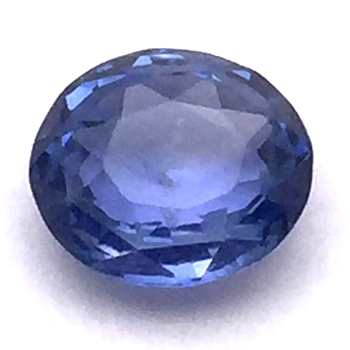

In [28]:
from IPython.display import Image
print("Синий сапфир")
Image("exammple_images/sapphire blue_0.jpg")

Танзанит


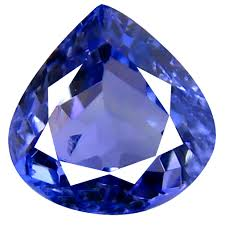

In [29]:
print("Танзанит")
Image("exammple_images/tanzanite_0.jpg")

А так же Черный оникс и Шпинель 

Черный оникс


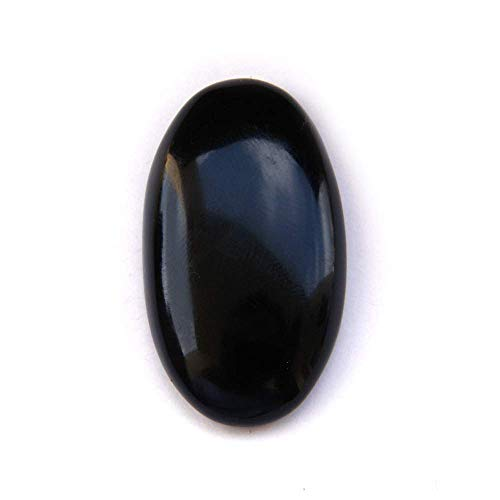

In [31]:
print("Черный оникс")
Image("exammple_images/onyx black_0.jpg")

Шпинель


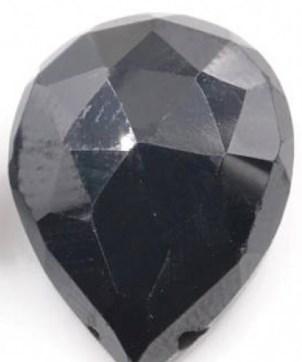

In [32]:
print("Шпинель")
Image("exammple_images/spinel_1.jpg")

Эти камни действительно очень похожи друг на друга особенно Синий сапфир и Танзанит.

## Использованые источники

* DeepSeek
* Kaggle